In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1  Train loss: 0.4836  Val loss: 0.3705  Val acc: 0.8380

Test Accuracy: 0.8260


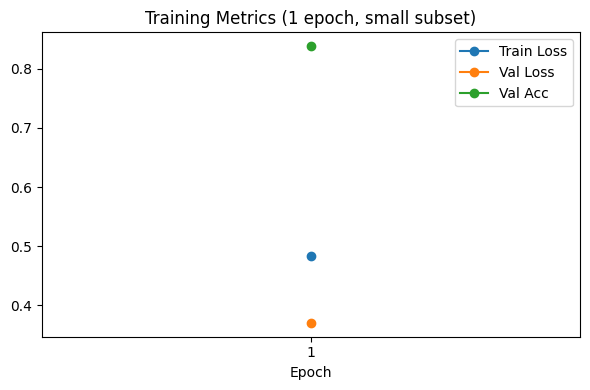

In [7]:
# bert_text_classification_fast.py
# Fine-tune BERT on a small IMDb subset for fast execution

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt

# 0. Config
model_checkpoint = 'bert-base-uncased'
batch_size = 16
epochs = 1
lr = 2e-5

# 1. Load & subsample IMDb
raw = load_dataset('imdb')
raw_train = raw['train'].shuffle(seed=42).select(range(2500))
train_val = raw_train.train_test_split(test_size=500, seed=42)
train_ds = train_val['train']   # 2000
val_ds   = train_val['test']    # 500
test_ds  = raw['test'].shuffle(seed=42).select(range(500))

# 2. Tokenizer + tokenize_fn
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)
def tokenize_fn(batch):
    return tokenizer(
        batch['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

# 3. Preprocess splits
def preprocess(split_ds):
    ds = split_ds.map(tokenize_fn, batched=True)
    ds = ds.rename_column('label', 'labels')
    ds = ds.remove_columns(['text'])
    ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])
    return ds

train_ds = preprocess(train_ds)
val_ds   = preprocess(val_ds)
test_ds  = preprocess(test_ds)

# 4. DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# 5. Model & optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2
).to(device)
optimizer = AdamW(model.parameters(), lr=lr)

# 6. Training
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch['input_ids'].to(device)
        masks  = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        out = model(inputs, attention_mask=masks, labels=labels)
        loss = out.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    val_metric = evaluate.load('accuracy')
    model.eval()
    total_vloss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            masks  = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            out = model(inputs, attention_mask=masks, labels=labels)
            total_vloss += out.loss.item()
            preds = out.logits.argmax(dim=-1)
            val_metric.add_batch(predictions=preds.cpu(), references=labels.cpu())
    avg_val_loss = total_vloss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = val_metric.compute()['accuracy']
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch}/{epochs}  "
        f"Train loss: {avg_train_loss:.4f}  "
        f"Val loss: {avg_val_loss:.4f}  "
        f"Val acc: {val_acc:.4f}"
    )

# 7. Test evaluation
test_metric = evaluate.load('accuracy')
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].to(device)
        masks  = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        out = model(inputs, attention_mask=masks)
        preds = out.logits.argmax(dim=-1)
        test_metric.add_batch(predictions=preds.cpu(), references=labels.cpu())
test_acc = test_metric.compute()['accuracy']
print(f"\nTest Accuracy: {test_acc:.4f}")

# 8. Visualization
plt.figure(figsize=(6,4))
plt.plot([1], train_losses,    marker='o', label='Train Loss')
plt.plot([1], val_losses,      marker='o', label='Val Loss')
plt.plot([1], val_accuracies,  marker='o', label='Val Acc')
plt.title('Training Metrics (1 epoch, small subset)')
plt.xlabel('Epoch')
plt.xticks([1])
plt.legend()
plt.tight_layout()
plt.show()
